# Baseline model for batch monitoring example

In [28]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric
from evidently.metrics import ColumnQuantileMetric, DatasetCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#### Q1. Prepare the dataset

Download the March 2023 Green Taxi data. What is the shape of the downloaded data? How many rows are there?


In [10]:
march = pd.read_parquet('C:/Users/Camila/OneDrive/Escritorio/mlops zoomcamp/data/green/green_tripdata_2023-03.parquet')

In [12]:
march.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72044 entries, 0 to 72043
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               72044 non-null  int32         
 1   lpep_pickup_datetime   72044 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  72044 non-null  datetime64[ns]
 3   store_and_fwd_flag     67507 non-null  object        
 4   RatecodeID             67507 non-null  float64       
 5   PULocationID           72044 non-null  int32         
 6   DOLocationID           72044 non-null  int32         
 7   passenger_count        67507 non-null  float64       
 8   trip_distance          72044 non-null  float64       
 9   fare_amount            72044 non-null  float64       
 10  extra                  72044 non-null  float64       
 11  mta_tax                72044 non-null  float64       
 12  tip_amount             72044 non-null  float64       
 13  t

In [13]:
# create target
march["duration_min"] = march.lpep_dropoff_datetime - march.lpep_pickup_datetime
march.duration_min = march.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [14]:
# filter out outliers
march = march[(march.duration_min >= 0) & (march.duration_min <= 60)]
march = march[(march.passenger_count > 0) & (march.passenger_count <= 8)]

<Axes: >

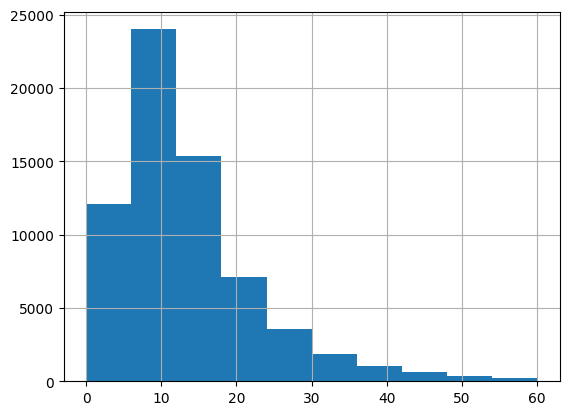

In [15]:
march.duration_min.hist()

In [16]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [17]:
march.shape

(66255, 21)

In [18]:
train_data = march[:30000]
val_data = march[30000:]

In [19]:
model = LinearRegression()

In [20]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [21]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [22]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [23]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.5641759571064915
3.646951695051198


# Dump model and reference data

In [25]:
with open('lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [26]:
val_data.to_parquet('reference.parquet')

# Evidently Report

In [29]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [31]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    DatasetCorrelationsMetric(),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
]
)

In [32]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [ ]:
report.show(mode='inline')

In [34]:
result = report.as_dict()

In [35]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.021912744737353405,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-29.976938687069854,
       -6.3604336636874805,
       17.256071359694893,
       40.872576383077266,
       64.48908140645963,
       88.10558642984202,
       111.72209145322438,
       135.33859647660674,
       158.95510149998913,
       182.5716065233715,
       206.18811154675387],
      'y': [9.343432451141254e-06,
       0.03443054858245553,
       0.007515623477886746,
       0.0003457070006922265,
       2.335858112785312e-05,
       8.175503394748602e-06,
       5.839645281963287e-06,
       1.1679290563926561e-06,
       2.3358581127853122e-06,
       1.1679290563926574e-06]}},
    'reference': {'small_distribution': {'x': [-44.794580269945776,
       -20.705700872

In [36]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.021912744737353405

In [37]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [38]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.0454570529456752

In [40]:
# value of metric `quantile = 0.5` on `"fare_amount"` column 
result['metrics'][4]['result']['current']['value']

12.8